In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(8)

165

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

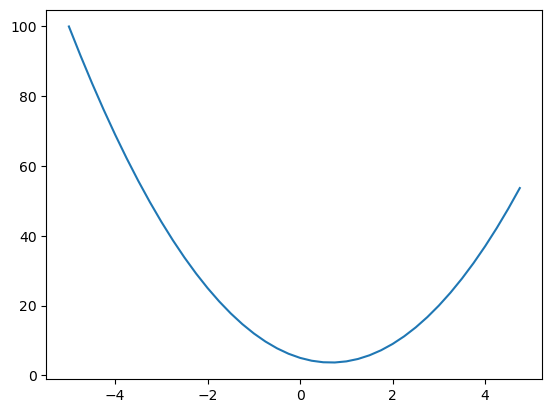

In [5]:
plt.plot(xs, ys)

## Derivatives

In [6]:
# derivative
h = 0.00000001
x = 2/3
(f(x +h) - f(x))/h

0.0

In [7]:
#lets more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2= a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data 
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visted = set()
        def build_topo(v):
            if v not in visted:
                visted.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    


In [10]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
        
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in graph, create a rectangulae('record') node for it
        dot.node(name= uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is the result of some operation, create an op node for import
            dot.node(name= uid + n._op, label= n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot
                 

In [11]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2, 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b 
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


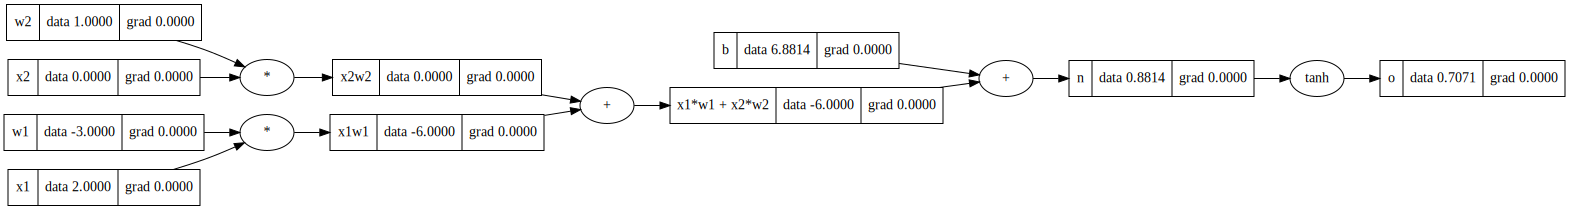

In [12]:
draw_dot(o)

In [13]:
o.backward()